## Predicting Bitcoin using closing price, volume total, and a sentiment indicator

### Using Multivariate LSTM

For this predicitve analysis we will use price_close, volume_total, and a sentiment
indicator as the input features, and we will be outputting a potential price_close variable.

#### resources
- https://alternative.me/crypto/fear-and-greed-index/#fng-history

In [1]:
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests 
from pandas.io.json import json_normalize
import math

Using TensorFlow backend.


In [9]:
URL = 'https://api.alternative.me/fng/?limit=0'
r = requests.get(url = URL) 
data = r.json()

values, value_classes, dates = [], [], []
for i in range(492):
    values.append(data['data'][i]['value'])
    value_classes.append(data['data'][i]['value_classification'])

### =============================== Getting relevant data + Some cleaning ====================================== ###

market_df = pd.read_csv('Desktop/Tech_Eval/market_data.csv')
market_df = market_df[['base_asset_id', 'epoch_ts', 'volume_total', 'price_close']]
market_df['epoch_ts'] = [date.split()[0] for date in market_df['epoch_ts']]

# This reverses the order of data so that first entry corresponds to Jan 01 , 2018
market_df = market_df.iloc[::-1]

btc = market_df.loc[market_df['base_asset_id'] == 'Bitcoin_BTC_BTC']
btc = btc.reset_index()
btc = btc.drop(columns=['base_asset_id', 'index'])
btc = btc.rename(index=str, columns={"epoch_ts": "date"})

### =============================== Getting relevant data + Some cleaning ====================================== ###
values = np.flip(values)
value_classes = np.flip(value_classes)

ndf = pd.DataFrame([np.array(btc['volume_total']), np.array(btc['price_close']),values, value_classes])
ndf = ndf.transpose()
ndf = ndf.rename(index=str, columns={0: "volume_total", 1: "price_close", 2: "sent_value", 3: "sent_class"})


ndf.dropna().head()
ndf = ndf.head(415)
ndf.head()

,volume_total,price_close,sent_value,sent_class
0,65288.6,13126.5,40,Fear
1,127958,14428.9,24,Fear
2,94730.5,14835.4,11,Extreme Fear
3,115541,14879.7,8,Extreme Fear
4,128986,16565.5,36,Fear


In [3]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 

# define input sequence
inseq1 = array(ndf['price_close'][0:-1])
inseq2 = array(ndf['volume_total'][0:-1])
inseq3 = array([int(i) for i in ndf['sent_value'][0:-1]])
outseq = array(ndf['price_close'][1:])

# convert to [rows, columns] structure
inseq1 = inseq1.reshape((len(inseq1), 1))
inseq2 = inseq2.reshape((len(inseq2), 1))
inseq3 = inseq3.reshape((len(inseq3), 1))
outseq = outseq.reshape((len(outseq), 1))

# horizontally stack columns
dataset = hstack((inseq1, inseq2, inseq3, outseq))
# choose a number of time steps
n_steps = 1

# convert into input/output
inputData, desiredOuts = split_sequences(dataset, n_steps)

# the dataset knows the number of features, e.g. 3
n_features = inputData.shape[2]

# define model
model = Sequential()
model.add(LSTM(40, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

trainlen = 365
trainX, testX = inputData[:trainlen], desiredOuts[:trainlen]
trainY, testY = inputData[trainlen:], desiredOuts[trainlen:]



Instructions for updating:
Colocations handled automatically by placer.


In [4]:
# fit model
model.fit(trainX, testX, epochs=200, verbose=0)

preds = []
for i in trainY:
    x_input = array(i)
    x_input = x_input.reshape((1, n_steps, 3))
    yhat = model.predict(x_input, verbose=0)[0][0]
    preds.append(yhat)
    
# eval model
mse = mean_squared_error(preds, testY)
print(math.sqrt(mse))

predb = pd.DataFrame(testY, preds)
predb = predb.reset_index()
predb = predb.rename(index=str, columns={"index": "actual", 0: "predicted"
                                        })
predb.head()

Instructions for updating:
Use tf.cast instead.
96.74633390061867


,actual,predicted
0,3840.573486,3903.596599
1,3890.237793,3801.733231
2,3793.643066,3841.942732
3,3848.138916,3825.080459
4,3833.933594,4044.170172


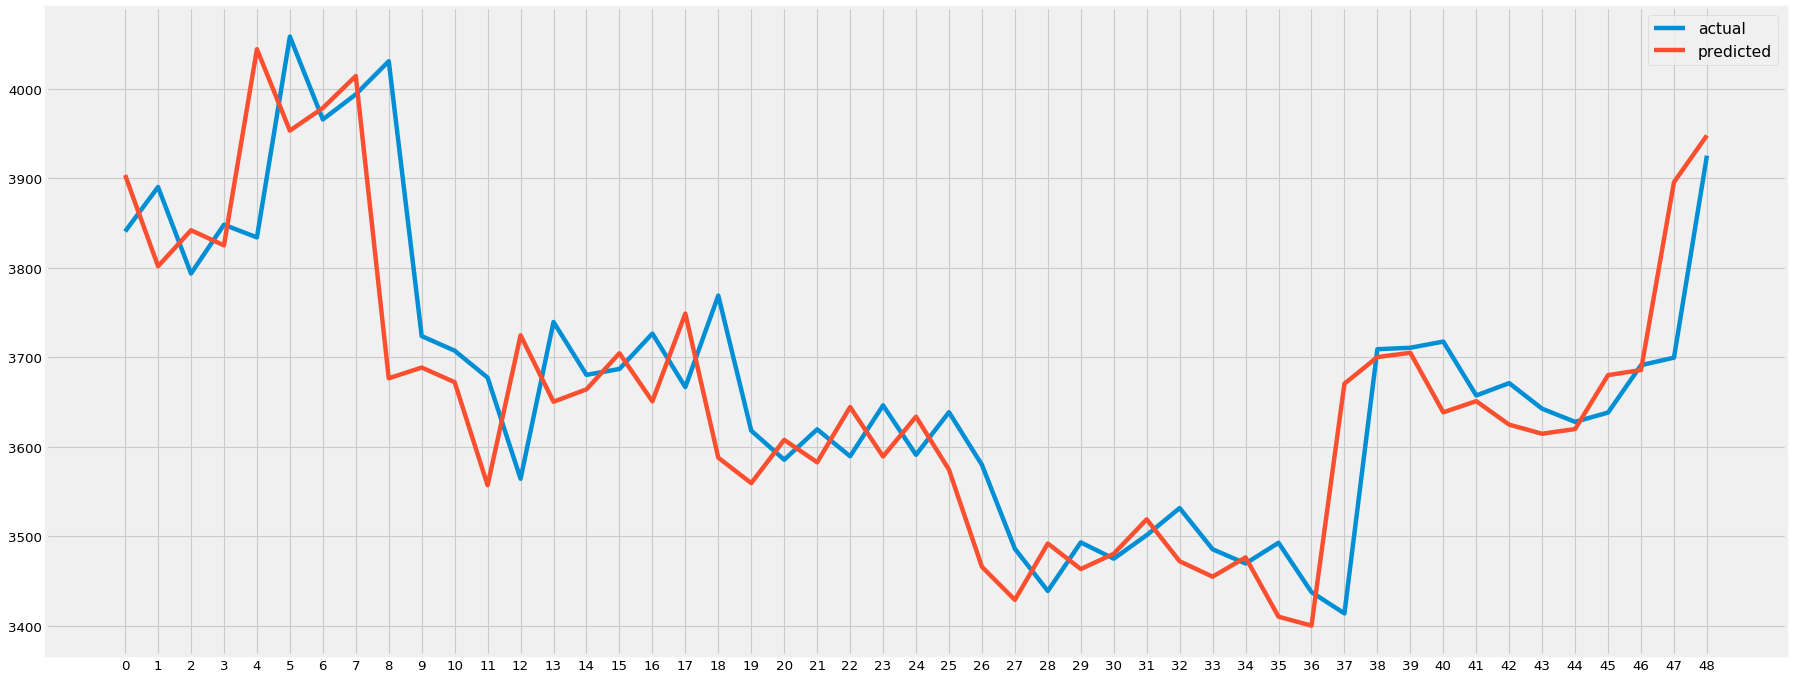

In [5]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.figure(figsize=(25, 10), dpi=80, facecolor = 'w', edgecolor = 'k')
plt.plot(predb['actual'], label='actual')
plt.plot(predb['predicted'], label='predicted')
plt.legend(loc = 'best')
plt.show()